In [4]:
# 
# Face Detection 코드 출처 : https://github.com/serengil/tensorflow-101/blob/master/python/opencv-dnn-face-detection.ipynb
# 45 * 34
# 55 * 43
import cv2
import numpy as np
import pandas as pd
from cvzone.SelfiSegmentationModule import SelfiSegmentation
# calculate temperature function
def max_mean(img_gray,points,minval,maxval):
    for i in range(len(points)):
        roi = img_gray[points[i][0]:points[i][1],points[i][2]:points[i][3]]
        print(roi.shape)
        # convert color to temperature
        roi= np.round(roi * (maxval-minval)/255 + minval,1)
    print(np.max(roi),np.mean(roi))

def makefacearea(image):
    detector = cv2.dnn.readNetFromCaffe("deploy.prototxt.txt", "res10_300x300_ssd_iter_140000.caffemodel")
    base_img = image.copy()
    original_size = image.shape
    target_size = (300, 300)
    image = cv2.resize(image, target_size)
    aspect_ratio_x = (original_size[1] / target_size[1])
    aspect_ratio_y = (original_size[0] / target_size[0])
    imageBlob = cv2.dnn.blobFromImage(image = image)
    detector.setInput(imageBlob)
    detections = detector.forward()
    detections_df = pd.DataFrame(detections[0][0]
        , columns = ["img_id", "is_face", "confidence", "left", "top", "right", "bottom"])
    detections_df = detections_df[detections_df['is_face'] == 1] #0: background, 1: face
    detections_df = detections_df[detections_df['confidence'] >= 0.90]
    mask = np.full(original_size[:2],0,np.uint8)
    points=[]
    for _, instance in detections_df.iterrows():
        left = int(instance["left"] * 300 * aspect_ratio_x)
        bottom = int(instance["bottom"] * 300 * aspect_ratio_y)
        right = int(instance["right"] * 300 * aspect_ratio_x)
        top = int(instance["top"] * 300 * aspect_ratio_y)
        points.append((top,bottom,left,right))
        cv2.rectangle(mask, (left,top),(right,bottom), (255, 255, 255), -1)
        cv2.rectangle(base_img, (left,top),(right,bottom), (255, 255, 255), 1)
    # cv2.imshow('Original',base_img)
    # cv2.imshow('Mask',mask)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    return base_img, mask, points

# image read
img_thermal_gray = cv2.imread('FLIR0064.jpg',cv2.IMREAD_GRAYSCALE)
#for line in img_thermal_gray:
#    print ('  '.join(map(str, img_thermal_gray)))
img_color = cv2.imread('FLIR0065.jpg')
minval = 18.8
maxval = 35.5
# resize color image
rh = 34/43 * 0.9
rw = 45/55 * 0.9
h,w,_ = img_color.shape
img_color = img_color[h//2-int((h*rh)//2):h//2+int((h*rh)//2),w//2-int((w*rw)//2)+15:w//2+int((w*rw)//2)+15]
img_color, mask, points= makefacearea(img_color)
img_color = cv2.resize(img_color,(320,240))
mask = cv2.resize(mask,(320,240))
img_fg = cv2.bitwise_and(img_thermal_gray,img_thermal_gray,mask=mask)
# thresholding thermal image
_, mask_thresh = cv2.threshold(img_fg,254,255,cv2.THRESH_BINARY)
img_thresh = cv2.bitwise_and(img_fg,img_fg,mask=mask_thresh)
max_mean(img_thermal_gray,points,minval,maxval)
# max_mean(img_thermal_gray,[(0,240,0,320)],minval,maxval)
cv2.imshow("Thermal Gray", img_thermal_gray)
cv2.imshow("Color", img_color)
cv2.imshow("face",img_fg)
cv2.imshow("Thresh",img_thresh)
cv2.waitKey(0)
cv2.destroyAllWindows()

error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\dnn\src\caffe\caffe_io.cpp:1126: error: (-2:Unspecified error) FAILED: fs.is_open(). Can't open "deploy.prototxt.txt" in function 'cv::dnn::ReadProtoFromTextFile'


(240, 320, 3)
(240, 320)
(20, 35)
(20, 35)
18.8

35.5



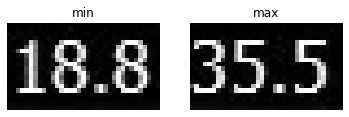

In [16]:
# 참고 https://ansan-survivor.tistory.com/313

import cv2
import os
import pytesseract
from PIL import Image
import matplotlib.pyplot as plt

# tesseract install path
#pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'

img = cv2.imread('FLIR0064.jpg')
print(img.shape)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(gray.shape)
min_img = gray[215:235,280:315]
print(min_img.shape)
max_img = gray[5:25,280:315]
print(max_img.shape)

# min 
filename ="{}.png".format(os.getpid())
cv2.imwrite(filename, min_img)
min = pytesseract.image_to_string(Image.open(filename), lang=None)
os.remove(filename)
print(min)

# max
filename ="{}.png".format(os.getpid())
cv2.imwrite(filename, max_img)
max = pytesseract.image_to_string(Image.open(filename), lang=None)
os.remove(filename)
print(max)

plt.subplot(1,2,1)
plt.imshow(min_img, cmap="gray")
plt.title('min')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(max_img, cmap="gray")
plt.title('max')
plt.axis('off')
plt.show()

#cv2.imshow('imag',gray)
#cv2.waitKey(0)
#cv2.destroyAllWindows()